In [3]:
import pandas as pd

In [4]:

df = pd.read_csv("../data/raw/kidney_disease_dataset.csv")

print("Shape:", df.shape)


Shape: (2304, 9)


### 1. Data Loading and Initial Inspection

In this section, we load the dataset and perform an initial inspection to understand
its structure, feature types, and potential data quality issues such as missing values.

Dataset size: 2,304 rows × 9 columns.

Next, we will (1) define the prediction target, (2) examine class balance, and (3) explore feature distributions and relationships.


In [5]:
df.head()


,Age,Creatinine_Level,BUN,Diabetes,Hypertension,GFR,Urine_Output,CKD_Status,Dialysis_Needed
0,71,0.30,40.9,0,1,46.8,1622.0,1,0
1,34,1.79,17.1,0,0,43.8,1428.0,1,0
2,80,2.67,15.0,0,1,78.2,1015.0,1,0
3,40,0.97,31.1,0,1,92.8,1276.0,1,0
4,43,2.05,22.8,1,1,62.2,1154.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2304 entries, 0 to 2303
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               2304 non-null   int64  
 1   Creatinine_Level  2304 non-null   float64
 2   BUN               2304 non-null   float64
 3   Diabetes          2304 non-null   int64  
 4   Hypertension      2304 non-null   int64  
 5   GFR               2304 non-null   float64
 6   Urine_Output      2304 non-null   float64
 7   CKD_Status        2304 non-null   int64  
 8   Dialysis_Needed   2304 non-null   int64  
dtypes: float64(4), int64(5)
memory usage: 162.1 KB


In [7]:
df.isnull().sum().sort_values(ascending=False)

Age                 0
Creatinine_Level    0
BUN                 0
Diabetes            0
Hypertension        0
GFR                 0
Urine_Output        0
CKD_Status          0
Dialysis_Needed     0
dtype: int64

## 2. Define Target and Check Class Balance

We choose **CKD_Status** as the primary prediction target. Before modeling, we check class balance because imbalance affects model choice and evaluation metrics.


In [8]:
df.columns

Index(['Age', 'Creatinine_Level', 'BUN', 'Diabetes', 'Hypertension', 'GFR',
       'Urine_Output', 'CKD_Status', 'Dialysis_Needed'],
      dtype='object')

In [9]:
target_col = "CKD_Status"
df[target_col].value_counts(dropna=False)

CKD_Status
1    1172
0    1132
Name: count, dtype: int64

In [10]:
df[target_col].value_counts(normalize=True)

CKD_Status
1    0.508681
0    0.491319
Name: proportion, dtype: float64

## 3. Exploratory Data Analysis (EDA)

We explore feature distributions and relationships with the target to understand signal, detect outliers, and guide preprocessing.


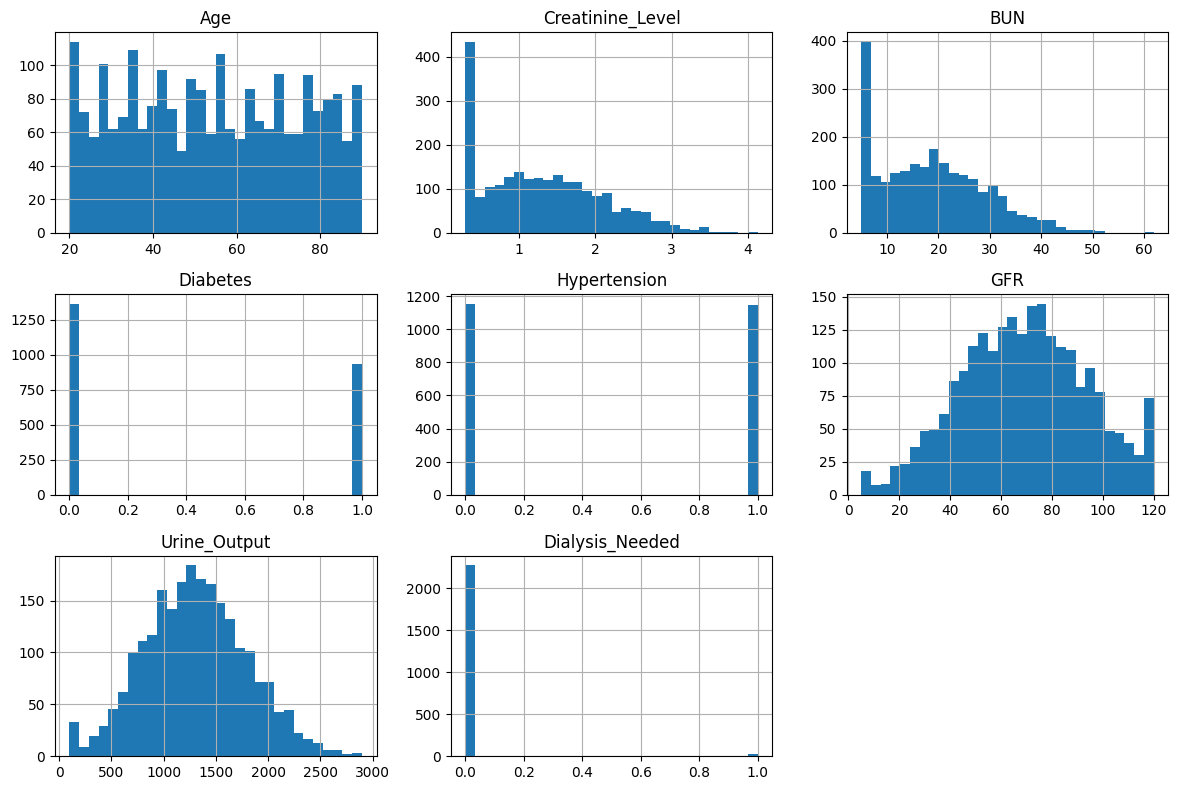

In [11]:
import matplotlib.pyplot as plt

numeric_cols = [c for c in df.columns if c != target_col]

df[numeric_cols].hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()


In [12]:
corr = df[numeric_cols + [target_col]].corr()
corr[target_col].sort_values(ascending=False)


CKD_Status          1.000000
BUN                 0.305803
Creatinine_Level    0.185017
Dialysis_Needed     0.114773
Diabetes            0.018322
Age                 0.012416
Hypertension       -0.027722
Urine_Output       -0.041600
GFR                -0.601672
Name: CKD_Status, dtype: float64

## 4. Baseline Model: Logistic Regression

We train a simple baseline model to predict CKD_Status and evaluate its performance.


In [13]:
X = df.drop(columns=["CKD_Status"])
y = df["CKD_Status"]

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [16]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])


In [17]:
pipe.fit(X_train, y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [19]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

y_proba = pipe.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


ROC-AUC: 0.9092449632837507

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84       226
           1       0.85      0.82      0.84       235

    accuracy                           0.84       461
   macro avg       0.84      0.84      0.84       461
weighted avg       0.84      0.84      0.84       461


Confusion Matrix:
 [[193  33]
 [ 42 193]]


In [20]:
from sklearn.metrics import average_precision_score

print("PR-AUC:", average_precision_score(y_test, y_proba))

PR-AUC: 0.9273140057469993


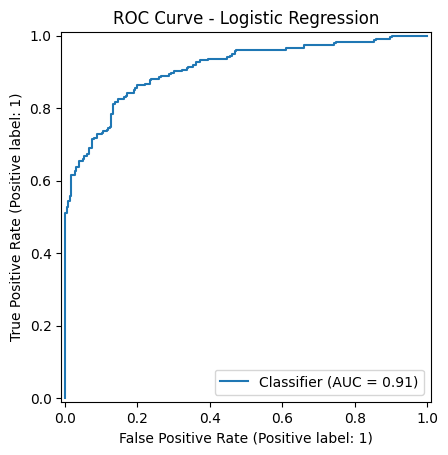

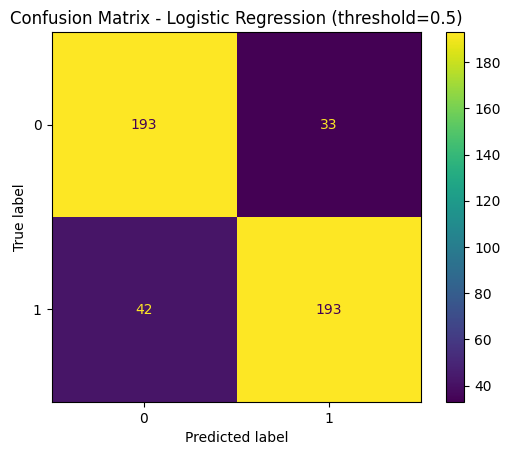

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - Logistic Regression")
plt.show()

#Confution matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix - Logistic Regression (threshold=0.5)")
plt.show()

In [22]:
threshold = 0.4
y_pred_04 = (y_proba >= threshold).astype(int)

from sklearn.metrics import confusion_matrix, classification_report
print("Threshold:", threshold)
print(confusion_matrix(y_test, y_pred_04))
print(classification_report(y_test, y_pred_04))

Threshold: 0.4
[[176  50]
 [ 31 204]]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81       226
           1       0.80      0.87      0.83       235

    accuracy                           0.82       461
   macro avg       0.83      0.82      0.82       461
weighted avg       0.83      0.82      0.82       461



In [ ]:

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_04)
plt.title("Confusion Matrix - Logistic Regression(threshold=0.4)")
plt.show